In [1]:
import pandas as pd

train = pd.read_csv('data/train_data.csv')
val = pd.read_csv('data/val_data.csv')
test = pd.read_csv('data/test_data.csv')

        
print(train.head())


   Transaction Amount  Account Balance  Transaction_To_Balance_Ratio  \
0            0.426854         0.824839                      0.025951   
1            0.775684         0.999824                      0.038824   
2            0.103696         0.469531                      0.011241   
3            0.954494         0.286136                      0.166418   
4            0.500826         0.988285                      0.025398   

   Is_High_Value_Transaction  High_Balance_flag  Branch_Frequency_Weight  \
0                          0                  1                   0.1288   
1                          1                  1                   0.1274   
2                          0                  0                   0.1268   
3                          1                  0                   0.1288   
4                          0                  1                   0.1259   

   Account_Transaction_Encoded  
0                         0.28  
1                         0.28  
2          

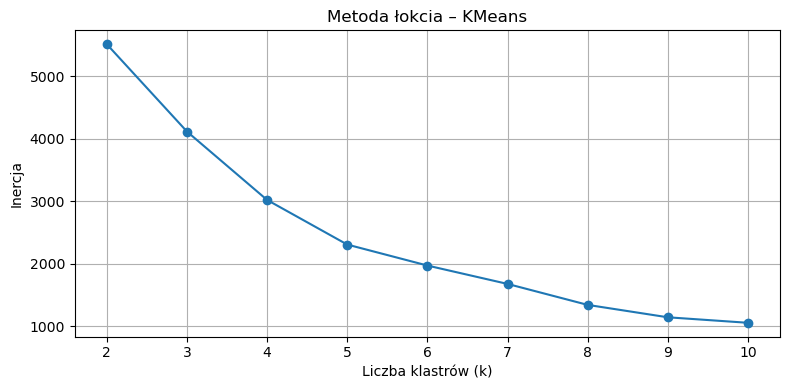

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Metoda łokcia – KMeans')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inercja')
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
k = 5 
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

train['KMeans_FE2'] = kmeans.fit_predict(train)
val['KMeans_FE2'] = kmeans.predict(val)
test['KMeans_FE2'] = kmeans.predict(test)
train.to_csv('data/train_data_clustered.csv', index=False)
val.to_csv('data/val_data_clustered.csv', index=False)
test.to_csv('data/test_data_clustered.csv', index=False)


In [4]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

X_only = train.drop(columns='KMeans_FE2')
sil_score = silhouette_score(X_only, train['KMeans_FE2'])
db_score = davies_bouldin_score(X_only, train['KMeans_FE2'])

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f} ")


Silhouette Score: 0.479
Davies-Bouldin Score: 0.735 


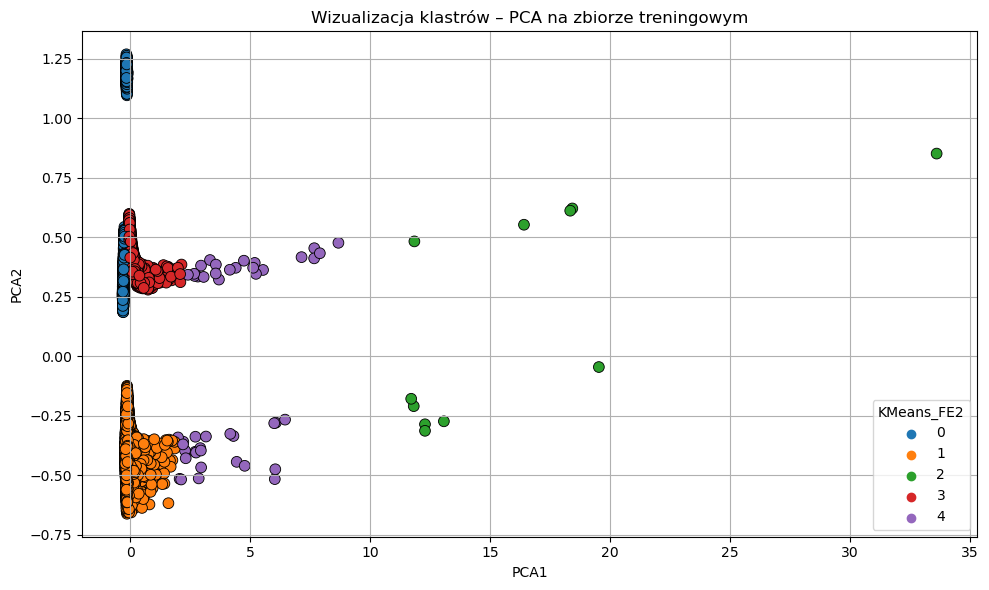

In [5]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_only)

train['PCA1'] = X_pca[:, 0]
train['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x='PCA1', y='PCA2', hue='KMeans_FE2', palette='tab10', s=60, edgecolor='black')
plt.title('Wizualizacja klastrów – PCA na zbiorze treningowym')
plt.grid(True)
plt.tight_layout()
plt.show()

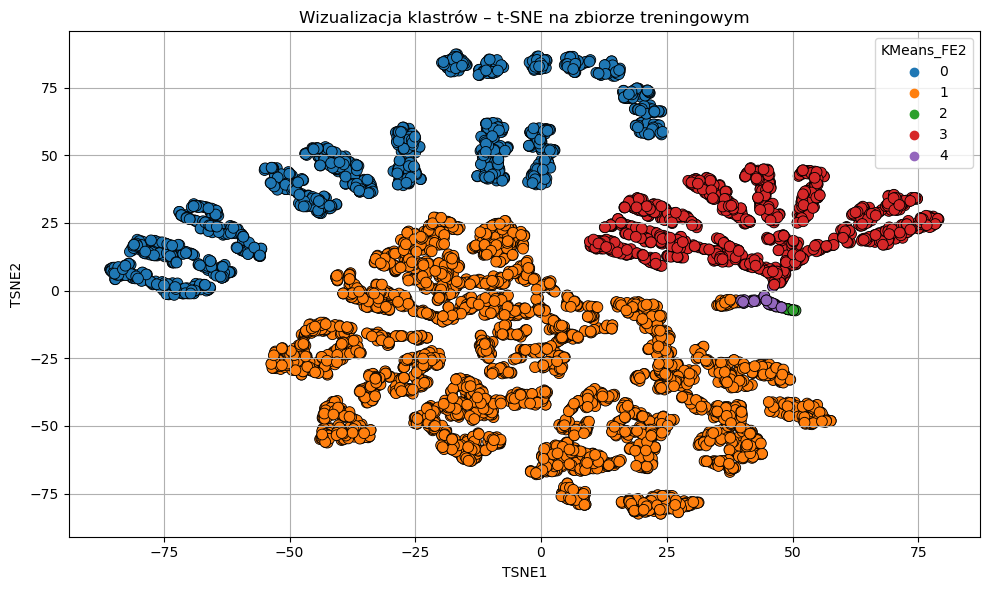

In [6]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
X_tsne_input = train.drop(columns=['KMeans_FE2'])
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_tsne_input)
train['TSNE1'] = X_tsne[:, 0]
train['TSNE2'] = X_tsne[:, 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=train,
    x='TSNE1',
    y='TSNE2',
    hue='KMeans_FE2',
    palette='tab10',
    s=60,
    edgecolor='black'
)
plt.title('Wizualizacja klastrów – t-SNE na zbiorze treningowym')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
cluster_profile = train.groupby('KMeans_FE2').mean().T.round(2)
display(cluster_profile)


KMeans_FE2,0,1,2,3,4
Transaction Amount,0.51,0.38,0.69,0.88,0.69
Account Balance,0.88,0.38,0.00,0.38,0.01
Transaction_To_Balance_Ratio,0.03,0.11,16.57,0.23,4.15
Is_High_Value_Transaction,0.25,0.00,0.45,1.00,0.45
High_Balance_flag,1.00,0.00,0.00,0.00,0.00
Branch_Frequency_Weight,0.11,0.11,0.13,0.11,0.11
Account_Transaction_Encoded,0.50,0.50,0.36,0.50,0.47
PCA1,-0.24,-0.06,16.30,0.15,4.02
PCA2,0.57,-0.39,0.16,0.43,-0.05
TSNE1,-30.57,-1.90,49.60,43.14,44.14


### **Klaster 0 — Stabilni zamożni klienci**
**Charakterystyka:**
- Wysokie saldo konta (`0.88`)
- Średnia kwota transakcji (`0.51`)
- Bardzo niska relacja transakcji do salda (`0.03`)
- 25% klientów wykonuje wysokie transakcje (`0.25`)
- Wszyscy oznaczeni flagą wysokiego salda (`1.00`)
- Umiarkowana aktywność transakcyjna (`0.50`)

*Interpretacja:* Klienci posiadający wysokie oszczędności, stabilni finansowo, raczej rzadko wykonujący duże transakcje. Niskie ryzyko zadłużenia. Grupa strategiczna dla banku.

---

### **Klaster 1 — Mało aktywni finansowo**
**Charakterystyka:**
- Niskie saldo konta (`0.38`)
- Niska aktywność transakcyjna (`0.38`)
- Relacja transakcji do salda (`0.11`)
- Brak wysokich transakcji (`0.00`)
- Brak flagi wysokiego salda (`0.00`)

*Interpretacja:* Klienci o minimalnej aktywności, prawdopodobnie rachunki dodatkowe, uśpione lub marginalnie wykorzystywane.

---

### **Klaster 2 — Klienci z ryzykiem zadłużenia**
**Charakterystyka:**
- Saldo bliskie zeru (`0.00`)
- Średnia kwota transakcji (`0.69`)
- Bardzo wysoka relacja transakcji do salda (`16.57`)
- 45% klientów wykonuje wysokie transakcje (`0.45`)
- Brak flagi wysokiego salda (`0.00`)

*Interpretacja:* Klienci o bardzo niskiej płynności finansowej, żyjący „od przelewu do przelewu”, często wykorzystujący dostępne środki do maksimum. Grupa o podwyższonym ryzyku kredytowym.

---

### **Klaster 3 — VIP / Premium**
**Charakterystyka:**
- Najwyższe kwoty transakcji (`0.88`)
- Średnie saldo konta (`0.38`)
- Relacja transakcji do salda (`0.23`)
- *Wszyscy* wykonują wysokie transakcje (`1.00`)
- Brak flagi wysokiego salda (`0.00`)

*Interpretacja:* Klienci premium, bardzo aktywni finansowo, wykonujący duże transakcje. Wysoka wartość dla banku.

---

### **Klaster 4 — Aktywni o umiarkowanym ryzyku płynnościowym**
**Charakterystyka:**
- Niskie saldo konta (`0.01`)
- Średnia kwota transakcji (`0.69`)
- Relacja transakcji do salda (`4.15`)
- 45% wykonuje wysokie transakcje (`0.45`)
- Brak flagi wysokiego salda (`0.00`)

*Interpretacja:* Klienci utrzymujący niskie saldo, ale regularnie wykonujący większe transakcje. Umiarkowane ryzyko płynnościowe, ale aktywność finansowa umiarkowana.
